##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Gemini 2.0 Image output

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Image_out.ipynb"><img src="https://ai.google.dev/site-assets/images/docs/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

This notebook will show you how to use the Image-out feature of Gemini, using the model multimodal capabilities to output both images and texts, and iterate on an image through a discussion.

This feature is very close to what the [Imagen](./Get_started_imagen.ipynb) offers but in a slightly different way as the Image-out feature has been developped to work iteratively so if you want to make sure certain details are clearly followed, and you are ready to itarate on the image until it's exactly what you envision, Image-out is for you.

Check the [documentation](https://ai.google.dev/gemini-api/docs/image-generation#choose-a-model) for more details ont both features and some more advices on when to use each one.

## Setup

### Install SDK

In [ ]:
!pip install -U -q "google-genai>=1.5.0"

### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [ ]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with you API key (or OAuth if using [Vertex AI](https://link_to_vertex_AI)). The model is now set in each call.

In [ ]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

### Select a model

Image-out is a new [Gemini 2.0](https://ai.google.dev/gemini-api/docs/models/gemini-v2) experimental capability, so at the moment you will have to use the `gemini-2.0.flash-exp`.

For more information about all Gemini models, check the [documentation](https://ai.google.dev/gemini-api/docs/models/gemini) for extended information on each of them.


In [ ]:
MODEL_ID = "gemini-2.0-flash-exp"

### Load modules


In [ ]:
import requests
import mimetypes
import os

### Utils

In [ ]:
from IPython.display import display, Markdown, Image
import pathlib


def display_response(response):
  for part in response.candidates[0].content.parts:
    if part.text is not None:
      display(Markdown(part.text))
    elif part.inline_data is not None:
      mime = part.inline_data.mime_type
      print(mime)
      data = part.inline_data.data
      display(Image(data=data))

def save_image(response, path):
  for part in response.candidates[0].content.parts:
    if part.text is not None:
      continue
    elif part.inline_data is not None:
      mime = part.inline_data.mime_type
      data = part.inline_data.data
      pathlib.Path(path).write_bytes(data)

## Generate images

Use `response_modalities` to indicate to the model that you are expeting an image in the ouput.

Remember that generating people is not allowed at the moment.

Okay, here's a 3D rendered image of a pig with wings and a top hat flying over a vibrant, futuristic city with lots of greenery:



image/png


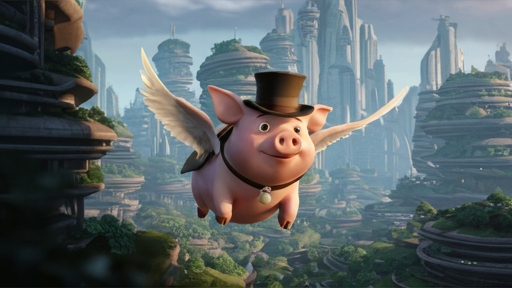

In [ ]:
contents = 'Hi, can create a 3d rendered image of a pig with wings and a top hat flying over a happy futuristic scifi city with lots of greenery?'

response = client.models.generate_content(
    model=MODEL_ID,
    contents=contents,
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image']
    )
)

display_response(response)
save_image(response, 'flying_pig.png')

## Edit images

You can also do image editing, simply pass the original one as part of the prompt.

Alright! Here's the same image but with a cat in the air instead of a pig!



image/png


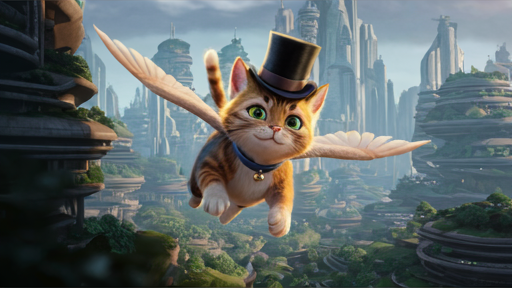

In [ ]:
import PIL

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        "Hey, could you edit this image to make a cat instead of a pig?",
        PIL.Image.open('flying_pig.png')
    ],
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image']
    )
)

display_response(response)
save_image(response, 'flying_cat.png')

## Get multiple images

So far you've only generated one image per call, but you can actually request way more than that! Let's try a chocolate cake receipe.

In [ ]:
contents = 'Show me how to cook a macaron with images.'

response = client.models.generate_content(
    model=MODEL_ID,
    contents=contents,
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image']
    )
)

display_response(response)

# Be careful; long output (see below)

The output of the previous code cell could not be saved in the notebook without making it too big to be managed by Github, but here's what it should look like when you run it:

----------

Okay! Let's embark on the delightful (and sometimes challenging!) journey of making macarons.  I'll provide step-by-step instructions with images to guide you.  

**Important Note:** Macarons are finicky. Success depends on accuracy and patience. Follow the instructions closely, especially with measurements.

**Recipe: Classic French Macarons**

**Ingredients:**

*   **For the Macaron Shells:**
    *   100 grams (about 1 cup) finely ground almond flour (almond meal is NOT the same)
    *   100 grams (about 1 cup) powdered sugar (also called confectioners' sugar or icing sugar)
    *   100 grams (about 1/2 cup) aged egg whites (about 3-4 large egg whites, separated a day or two in advance and stored in an airtight container in the fridge). Room temperature when using.
    *   50 grams (about 1/4 cup) granulated sugar
    *   Pinch of salt
    *   Optional: gel food coloring (not liquid!)

*   **For the Filling (you can choose your favorite, this is for a simple vanilla buttercream):**
    *   100 grams (about 1/2 cup) unsalted butter, softened
    *   200 grams (about 1 3/4 cups) powdered sugar, sifted
    *   1-2 tablespoons milk or cream
    *   1 teaspoon vanilla extract

**Equipment:**

*   Kitchen scale (highly recommended for accuracy)
*   Fine-mesh sieve
*   Stand mixer or hand mixer with whisk attachment
*   Rubber spatula
*   Piping bag fitted with a round tip (about 8-10mm)
*   Baking sheets
*   Parchment paper or silicone baking mats
*   Toothpick or scribe

**Let's Begin!**

**Step 1: Prepare the Dry Ingredients**

![Macaron prepartation step 1](https://storage.googleapis.com/generativeai-downloads/images/macaron_step1.png)


1.  In a large bowl, combine the **almond flour** and **powdered sugar**.
2.  Sift the mixture through a fine-mesh sieve into another bowl. This removes any lumps and ensures a smooth batter. Discard any large pieces left in the sieve.
3. Set the bowl aside.

**Step 2: Whip the Egg Whites**

![Macaron prepartation step 2](https://storage.googleapis.com/generativeai-downloads/images/macaron_step2.png)

1. In a clean and dry mixing bowl, add the room-temperature **egg whites** and **salt**.
2. Using a stand mixer or hand mixer with the whisk attachment, beat on medium speed until soft peaks form.
3. Gradually add the **granulated sugar** a little at a time while continuing to beat. Increase the speed to medium-high.
4. Beat until stiff, glossy peaks form. The meringue should hold its shape and have a shiny appearance. If using gel food coloring, add a couple of drops now and beat until combined.

**Step 3: The Macaronage (Folding)**

![Macaron prepartation step 3](https://storage.googleapis.com/generativeai-downloads/images/macaron_step3.png)

1. Add about 1/3 of the sifted dry ingredient mixture to the meringue.
2. Using a rubber spatula, gently fold the dry ingredients into the meringue. You want to cut through the center, rotate your bowl slightly and pull up from the bottom and over. This is a technique to incorporate air and flatten it.
3. Add the remaining dry ingredients in two more additions, folding each time.
4. Continue the folding process until the batter is smooth, shiny, and flows like lava. When you lift the spatula, it should form a ribbon that slowly falls back into the bowl and disappears in about 20 seconds. This is often referred to as achieving the "ribbon stage" or "lava consistency". Do not over-mix.

**Step 4: Piping**

![Macaron prepartation step 4](https://storage.googleapis.com/generativeai-downloads/images/macaron_step4.png)

1. Line your baking sheets with parchment paper or silicone mats. It might help to trace circles on the parchment paper beforehand.
2. Transfer the batter to your piping bag.
3. Holding the piping bag straight above the baking sheet, pipe even circles about 1.5 inches (3.8 cm) in diameter, leaving some space between each one.
4. Once you finish piping, gently tap the baking sheet on your counter to remove air bubbles in the batter.  
5. If you see a few small bubbles, use a toothpick or scribe to gently pop them.

**Step 5: Drying (Skin Formation)**

![Macaron prepartation step ](https://storage.googleapis.com/generativeai-downloads/images/macaron_step5.png)

1. Allow the piped macaron shells to sit at room temperature for 30-60 minutes, or until a thin skin forms on top. You should be able to gently touch them without the batter sticking to your finger. If your environment is humid, the drying time will be longer.

**Step 6: Baking**

And that's it folk!

## Chat (recommended)

So far you've used unary calls, but Image-out is actually made to work better with chat mode as it's easier to iterate on an image turn after turn.

In [ ]:
chat = client.chats.create(
    model=MODEL_ID,
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image']
    )
)

Okay, here's an image of a realistic-looking giraffe with a bird on its head, and a lion in the background.



image/png


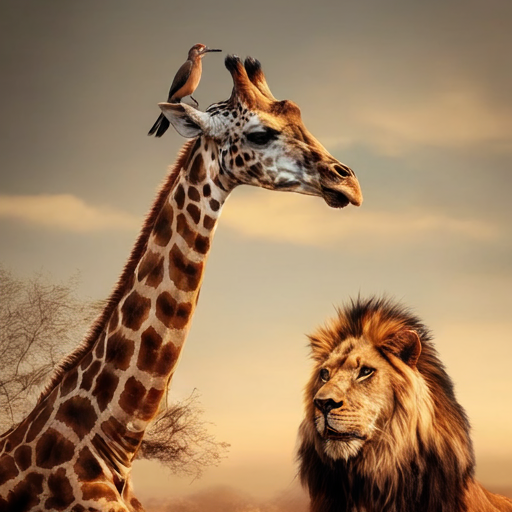

In [ ]:
response = chat.send_message('can you draw a realistic looking giraffe, with a bird on it\'s head, and a lion the background?')
display_response(response)

Okay, here's a cartoon-style image of a giraffe with a bird on its head, and a lion in the background.



image/png


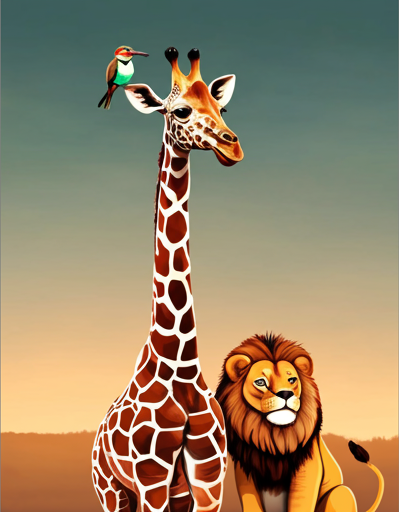

In [ ]:
response = chat.send_message('Can you use a cartoon style instead?')
display_response(response)

Alright, here's a cartoon-style image with a giraffe, a rainbow, lots of colorful birds, and a lion in the background!



image/png


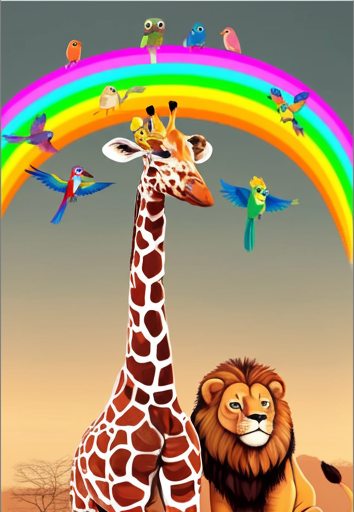

In [ ]:
response = chat.send_message('Can you add a rainbow and some colorful birds?')
display_response(response)

## Next Steps
### Useful documentation references:

Check the [documentation](https://ai.google.dev/gemini-api/docs/image-generation#gemini) for more details about the image generation capabilities of the model.To improve your prompting skills, check the [Imagen prompt guide](https://ai.google.dev/gemini-api/docs/imagen-prompt-guide) for great advices on creating your prompts.

### Check-out Imagen as well:
The [Imagen](https://ai.google.dev/gemini-api/docs/image-generation#imagen) model is another way to generate images. Check out the [Get Started with Imagen notebook](./Get_started_imagen.ipynb) to start playing with it too.

Here are some Imagen examples to get your imagination started on how to use it in creative ways:
*  [Illustrate a book](../examples/Book_illustration.ipynb): Use Gemini and Imagen to create illustration for an open-source book

### Continue your discovery of the Gemini API

Gemini is not only good at generating images, but also at understanding them. Check the [Spatial understanding](./Spatial_understanding.ipynb) guide for an introduction on those capabilities, and the [Video understanding](./Video_understanding.ipynb) one for video examples.
